# Data Env

In [74]:
import pandas as pd
import numpy as np

''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as pyoff
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

'''Sklearn'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import set_config
set_config(display='diagram')

'''gensim'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML

In [2]:
#read cleaned data
from ast import literal_eval
data = pd.read_csv("../Data/StackOverflow_questions_2009_2020_cleaned.csv",
                   sep=";", index_col=0, 
                   converters={"Title": literal_eval,
                               "Body": literal_eval,
                               "Tags": literal_eval})
data.head(5)

Title  \
Id                                      
4                           [decimal]   
13                   [user, timezone]   
19                       [way, value]   
123  [java, lib, app, csv, xml, file]   
888                     [php, script]   

                                                  Body  Score  \
Id                                                              
4    [variable, trans, variable, opacity, app, erro...    792   
13   [way, web, server, user, timezone, web, page, ...    698   
19   [way, value, challenge, way, constant, number,...    350   
123  [application, library, java, data, file, file,...    120   
888  [php, script, debugging, error, reporting, bre...    403   

                         Tags  
Id                             
4                        [c#]  
13                     [html]  
19   [performance, algorithm]  
123                    [java]  
888            [php, eclipse]

In [3]:
data.shape

(76060, 4)

# Preproc 

In [4]:
data["Full_doc"] = data["Title"] + data["Body"]
data["Full_doc"].head(5)

Id
4      [decimal, variable, trans, variable, opacity, ...
13     [user, timezone, way, web, server, user, timez...
19     [way, value, way, value, challenge, way, const...
123    [java, lib, app, csv, xml, file, application, ...
888    [php, script, php, script, debugging, error, r...
Name: Full_doc, dtype: object

In [5]:
#Define X & y
X = data["Full_doc"]
y = data["Tags"]

# Initialize the "CountVectorizer" for Full_doc
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of X: (76060, 636)
Shape of y: (76060, 50)


In [6]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (53242, 636)
X_test shape : (22818, 636)
y_train shape : (53242, 50)
y_test shape : (22818, 50)


# Unsurpervised Modelling 

In [7]:
# Create dic (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2)]]


In [8]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('app', 1),
  ('decimal', 1),
  ('error', 1),
  ('opacity', 1),
  ('trans', 1),
  ('type', 1),
  ('variable', 2)]]

In [15]:
# Build LDA model
lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.011347148856493

Coherence Score:  0.42858266136393464


In [16]:
pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(lda_model, corpus, id2word)

/Users/oumniasadaouni/.pyenv/versions/3.8.6/envs/pix2pix/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.157326 -0.037963       1        1  9.399215
5     -0.117635 -0.016074       2        1  8.704000
6     -0.062819 -0.103370       3        1  6.869986
14     0.120356 -0.005177       4        1  6.240145
9      0.075209  0.037332       5        1  6.057714
19     0.043783  0.040349       6        1  5.528292
0     -0.064742 -0.018153       7        1  5.510857
16    -0.001350  0.063679       8        1  5.447440
18    -0.063325 -0.083851       9        1  4.981741
1     -0.102721  0.173242      10        1  4.499192
10     0.023397 -0.029253      11        1  4.461138
17    -0.100259 -0.041363      12        1  4.234285
12     0.003702 -0.011678      13        1  3.967502
2     -0.023719  0.005401      14        1  3.754645
13     0.126565  0.070110      15        1  3.748295
7     -0.037130 -0.002152      16        1  3.667099
3      0.003447  0.024077      17        1  3.440435
8      0.052119 -0.034447      18        1  3.371091
4      0.031901 -0.077782      19        1  3.176670
11    -0.064106  0.047074      20        1  2.940258, topic_info=          Term          Freq         Total Category  logprob  loglift
48        file  35374.000000  35374.000000  Default  30.0000  30.0000
85       class  23157.000000  23157.000000  Default  29.0000  29.0000
11      string  15511.000000  15511.000000  Default  28.0000  28.0000
5         type  18190.000000  18190.000000  Default  27.0000  27.0000
307      image  10225.000000  10225.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
14         way    825.371100  29978.291510  Topic20  -4.5136  -0.0657
34      script    546.241090   7045.477704  Topic20  -4.9263   0.9696
1183   android    560.477755   8424.618620  Topic20  -4.9006   0.8165
6     variable    504.828567   7989.515829  Topic20  -5.0052   0.7650
29      number    509.130386  14607.312195  Topic20  -4.9967   0.1701

[1721 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
7014      12  0.936511            aaaa
8037      20  0.938748       accessory
9866      15  0.868829  accountmanager
7980       7  0.973218    accumulation
10122      2  0.007533       actionbar
...      ...       ...             ...
4136      13  0.067984            zoom
4136      14  0.006798            zoom
4136      16  0.639048            zoom
4136      17  0.020395            zoom
4136      19  0.013597            zoom

[10752 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 6, 7, 15, 10, 20, 1, 17, 19, 2, 11, 18, 13, 3, 14, 8, 4, 9, 5, 12])

## LDA optimization 

In [24]:
import time
# Iteration
# best number of topics?
coherence_test = []
for k in np.arange(1,90,9):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model_ = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda_ = CoherenceModel(model=lda_model_,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda_.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 10
Fitting LDA for K = 19
Fitting LDA for K = 28
Fitting LDA for K = 37
Fitting LDA for K = 46
Fitting LDA for K = 55
Fitting LDA for K = 64
Fitting LDA for K = 73
Fitting LDA for K = 82


In [25]:
# coherence scores into a dataframe
coherence_scores = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_scores

k  coherence       time
0   1   0.405238  19.065785
1  10   0.433729  42.165136
2  19   0.420873  47.462531
3  28   0.415943  51.632120
4  37   0.418547  56.398006
5  46   0.411376  60.687307
6  55   0.411205  62.941259
7  64   0.408750  66.441810
8  73   0.401835  71.007705
9  82   0.396362  74.892917

In [26]:
# Select best number of topics
best_topics_k = coherence_scores\
                    .loc[coherence_scores.coherence.argmax(),"k"]
print('Optimal number of topics:', best_topics_k)

Optimal number of topics: 10


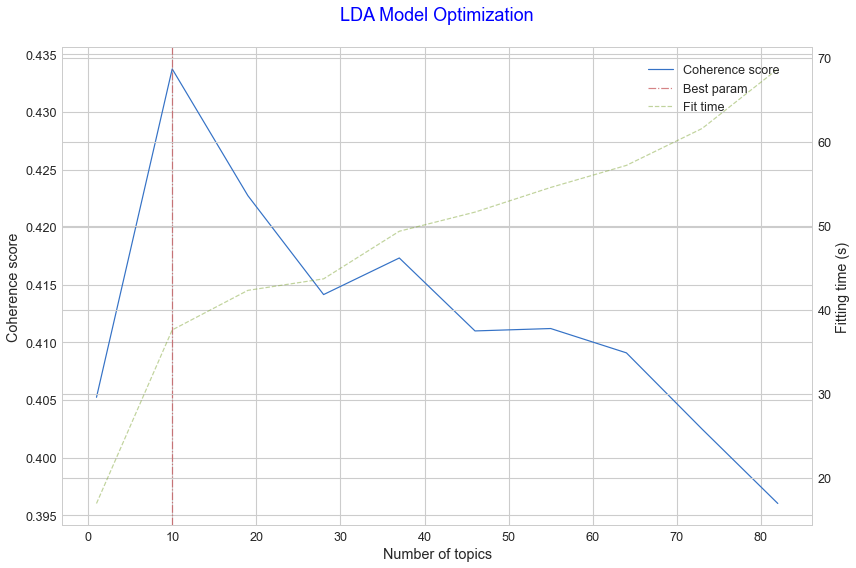

In [20]:
#Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_scores["k"]
y1 = coherence_scores["coherence"]
y2 = coherence_scores["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_topics_k, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of topics")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("LDA Model Optimization\n",
          color="blue", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

## Reducing the range of number of topics 

In [21]:
coherence_test = []
for k in np.arange(1,20,2):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model_ = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda_ = CoherenceModel(model=lda_model_,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda_.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 3
Fitting LDA for K = 5
Fitting LDA for K = 7
Fitting LDA for K = 9
Fitting LDA for K = 11
Fitting LDA for K = 13
Fitting LDA for K = 15
Fitting LDA for K = 17
Fitting LDA for K = 19


In [22]:
# coherence scores with the new range into a dataframe
coherence_scores = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_scores

k  coherence       time
0   1   0.405238  20.357339
1   3   0.401154  39.206312
2   5   0.405015  40.365884
3   7   0.423549  42.961209
4   9   0.433053  43.939020
5  11   0.435295  44.848187
6  13   0.431968  45.411299
7  15   0.427045  47.295018
8  17   0.425162  46.735170
9  19   0.422281  49.197849

In [23]:
# Select best number of topics
best_topics_k = coherence_scores\
                    .loc[coherence_scores.coherence.argmax(),"k"]
print('Optimal number of topics:', best_topics_k)

Optimal number of topics: 11


## Initialize with best topics number

In [29]:
#re-initialize with best topics number 
best_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=best_topics_k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
gensimvis.prepare(best_lda_model, corpus, id2word)

/Users/oumniasadaouni/.pyenv/versions/3.8.6/envs/pix2pix/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.035285 -0.109804       1        1  14.522244
9     -0.016261  0.080808       2        1  13.315278
8     -0.087806  0.079997       3        1  13.296757
6     -0.032251 -0.074064       4        1  11.317149
0     -0.004138 -0.064072       5        1   9.694439
4     -0.075818 -0.006751       6        1   8.077875
3      0.021952  0.044128       7        1   8.027503
1      0.168311  0.047003       8        1   7.736675
7     -0.007796 -0.027144       9        1   7.367000
2     -0.001478  0.029899      10        1   6.645080, topic_info=         Term          Freq         Total Category  logprob  loglift
85      class  22185.000000  22185.000000  Default  30.0000  30.0000
48       file  34835.000000  34835.000000  Default  29.0000  29.0000
11     string  14902.000000  14902.000000  Default  28.0000  28.0000
416     array  13620.000000  13620.000000  Default  27.0000  27.0000
117     table  10455.000000  10455.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
223     issue    900.238988  12395.373701  Topic10  -5.2421   0.0889
13       user    895.971628  14989.931612  Topic10  -5.2469  -0.1059
10     server    844.666608  13073.918926  Topic10  -5.3058  -0.0281
137  function    845.635940  26747.997978  Topic10  -5.3047  -0.7428
441   element    812.696714  10623.356173  Topic10  -5.3444   0.1408

[922 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
7980      5  0.930476  accumulation
1182      1  0.008066      activity
1182      2  0.114323      activity
1182      3  0.753969      activity
1182      4  0.015781      activity
...     ...       ...           ...
2910      7  0.004910           zip
2910      8  0.002455           zip
2910      9  0.007364           zip
2910     10  0.014729           zip
5286      8  0.968162        zipper

[3861 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 9, 7, 1, 5, 4, 2, 8, 3])

In [28]:
from imp import reload

In [30]:
#  Document X topic matrix with Gensim
doc_topic = pd.DataFrame(best_lda_model\
                             .get_document_topics(corpus,
                                                minimum_probability=0))

for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y_binarized.shape)
print('document/topic : ', doc_topic.shape)
doc_topic.head(3)

document/tag :  (76060, 50)
document/topic :  (76060, 10)


0         1         2         3         4         5         6  \
0  0.011204  0.011204  0.011201  0.011201  0.011202  0.478926  0.011203   
1  0.007694  0.007694  0.255506  0.682936  0.007695  0.007695  0.007695   
2  0.002176  0.002176  0.002176  0.002176  0.410490  0.468589  0.002176   

          7         8         9  
0  0.149133  0.011205  0.293521  
1  0.007694  0.007696  0.007695  
2  0.105691  0.002176  0.002176

/Users/oumniasadaouni/.pyenv/versions/3.8.6/envs/pix2pix/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/oumniasadaouni/.pyenv/versions/3.8.6/envs/pix2pix/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/oumniasadaouni/.pyenv/versions/3.8.6/envs/pix2pix/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/oumniasadaouni/.pyenv/versions/3.8.6/envs/pix2pix/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation fo

In [31]:
y_binarized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
#topic X tags matrix
# Matricial multiplication with DocumentXTopics transpose
topic_tag = np.matmul(doc_topic.T, y_binarized) # rows represent topics
print(topic_tag.shape) # columns represent the disctribution of the associated tags
topic_tag

(10, 50)


0           1            2           3           4           5   \
0  394.199794  264.516136   129.454642   35.064027   95.178835   42.911831   
1   96.722657  646.046998   586.648406  149.135816   54.630446   41.970582   
2  264.590428  245.850787   158.093927   74.652823   54.440623  108.894135   
3  168.124685  243.364961   453.693604  120.215226   30.371355  109.087992   
4  319.865813  114.067923   143.996277   28.217155   31.794964  119.507292   
5  354.097318  984.246206   119.301658   73.949803  956.720924   40.309701   
6  563.502928   41.986024   307.798153   61.079214   59.358850   72.898475   
7  275.688831  104.012441   573.184567   31.541112   39.306626   62.125468   
8  406.082019   25.609088  1979.868015  138.686352   18.990824  325.084093   
9  414.125524   45.299432  1149.960751   94.458471   33.206554  198.210432   

           6           7            8            9   ...          40  \
0   11.466039   28.213039   792.906421   952.252876  ...   42.095548   
1   66.113058   34.587906   264.701601   432.120952  ...   55.512964   
2   59.342043   96.266410   171.693387   740.057416  ...   88.288607   
3   67.136060   10.084948   109.783852   489.686745  ...   44.711322   
4  110.280299   16.884184   110.559741   989.158111  ...   48.050668   
5   29.273808   47.769326  1596.250953  1307.632602  ...  140.186676   
6   61.516799    6.615308   368.580652  1657.006309  ...   58.426216   
7   90.973618   17.707385   477.664961   820.206521  ...   43.639006   
8  193.662553   50.993998   211.303074  1045.353876  ...  226.187779   
9  134.235722  287.877498   376.555357  1166.524586  ...   93.901215   

           41          42           43          44          45          46  \
0   18.899306   14.430012   195.840086  106.239662   89.993381   30.336027   
1   58.036873   11.237164    69.211394   35.306944   59.272505  129.279886   
2   96.559066   39.653130    59.368468   33.795692  480.306268   27.264686   
3   45.995402   14.020102    65.330790   30.677779   19.882756   41.201107   
4   98.653979  159.956299  1018.305011  642.954251   28.795561   24.657734   
5   29.656191    7.926293   105.126317   56.367314  331.690615  219.508359   
6   36.353297  219.749686    24.705817   15.891100   63.038825  100.601914   
7   44.722194   23.363410    19.862108    8.165433   71.568697   85.760381   
8  330.227704   80.702471    83.354452  129.824309   17.809100  137.563612   
9   96.895988   60.961433    38.895556   33.777514   41.642290   71.826293   

           47          48          49  
0   23.121175   86.300152   16.353214  
1   13.643864   25.119794   63.686808  
2   23.400211   52.677010   13.481060  
3   17.117945   55.681211   21.428852  
4   35.752952   44.603357   21.361615  
5   38.311724   34.598669   38.357915  
6  127.794447   34.781692   62.750150  
7   34.662464   81.545627   71.191819  
8   51.969092  200.941047  368.322584  
9  344.226126  508.751443  114.065984  

[10 rows x 50 columns]

In [33]:
# dataframe of predictions
y_results = pd.DataFrame(y)
y_results["rep_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

In [34]:
y_results

Tags  rep_topic  nb_tags
Id                                                    
4                             [c#]          5        1
13                          [html]          3        1
19        [performance, algorithm]          5        2
123                         [java]          9        1
888                 [php, eclipse]          6        2
...                            ...        ...      ...
36371706     [arrays, performance]          5        2
36371748            [java, spring]          9        2
36372274                     [git]          5        1
36372525                      [c#]          9        1
36372611              [javascript]          7        1

[76060 rows x 3 columns]

In [37]:
#groupby y binarized index
df_y_2 = pd.DataFrame(y_binarized)
df_dict = dict(list(df_y_2.groupby(df_y_2.index)))

#intiate a list of tags numbers 
num_tags = []
for key, value in df_dict.items():
    check = value.columns[(value == 1).any()]
    num_tags.append(check.to_list())
print(num_tags)

[[9], [20], [1, 35], [23], [15, 36], [29], [36], [0, 34, 35], [43, 44], [0, 9], [28, 44], [44], [37], [8, 10], [0, 9], [43], [0], [36], [31], [8], [40, 45], [17, 48], [8, 28], [6], [30], [12, 20], [1, 10, 34], [24], [48], [0, 9], [31, 35], [43], [47], [23], [21, 22, 48], [23], [24], [37], [31], [23], [10], [10, 35], [0, 9, 35], [37], [0, 9], [12], [23], [10], [1], [23], [23, 45], [8, 10], [9], [8, 10], [1], [9], [8], [8], [23], [19], [12], [5, 47], [8, 10], [31], [20, 24, 39], [0, 9], [37], [1, 9], [48], [8, 10], [48], [23], [45], [0, 9], [23], [44], [24], [10], [0], [0, 9], [37], [7], [37], [10], [48], [24], [24], [44], [8, 10], [36], [20], [20, 24], [9], [37], [7], [9], [36, 39], [9, 48], [20, 24], [1], [1], [37], [20], [0, 9], [15], [1, 35], [1], [10], [7, 27], [47], [24], [10, 16], [9], [23], [8], [8, 10], [0, 9], [20], [9], [47], [18, 24], [28], [5, 6], [7, 27], [0, 9], [12, 20], [1], [1, 9], [47], [17], [24], [24], [26, 40, 41], [37], [17], [12, 20], [36], [9], [7], [23], [10, 24

In [39]:
y_binarized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
y_results["y_true"] = num_tags
y_results.head(3)

Tags  rep_topic  nb_tags   y_true
Id                                                       
4                       [c#]          5        1      [9]
13                    [html]          3        1     [20]
19  [performance, algorithm]          5        2  [1, 35]

In [43]:
# Selecting predicted tags from Topics X Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.rep_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results.head(3)

Tags  rep_topic  nb_tags   y_true   y_pred
Id                                                                
4                       [c#]          5        1      [9]     [10]
13                    [html]          3        1     [20]     [24]
19  [performance, algorithm]          5        2  [1, 35]  [10, 8]

## LDA Model evaluation

In [73]:
metrics

<function __main__.metrics(model, df, y_true, y_pred)>

In [76]:
def metrics_scores(model, df, y_true, y_pred):
    if(df is not None):
        scores_df = df
    else:
        scores_df = pd.DataFrame(index=["Accuracy", "F1",
                                         "Recall",
                                         "Precision"],
                                          columns=[model])
    #intiate scores' list
    scores = []
    #append scores
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    scores_df[model] = scores
    
    return scores_df

In [77]:
# Create matrix for predicted and true tags y
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [78]:
#create df of lds metrics chosen above
df_metrics = metrics_scores("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics

/Users/oumniasadaouni/.pyenv/versions/3.8.6/envs/pix2pix/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



LDA
Accuracy   0.128517
F1         0.292303
Recall     0.222257
Precision  0.159695

**LDA non supervised approach is not adapted seen the scores results.**

# Supervised Approach 

## Logistic Regression

### Logit Grid search

In [47]:
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

#Grid search best params
multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [49]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [50]:
logit_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     172.865808      5.418291         0.396870        0.047698   
1      53.381529      1.109949         0.385268        0.061801   
2      87.215661      0.770358         0.378317        0.027185   
3      31.797931      0.126276         0.400381        0.055307   
4      35.044700      0.350317         0.397419        0.043636   
5      21.336147      1.679328         0.463036        0.083247   
6      18.235197      0.916856         0.460263        0.065727   
7      13.484817      3.024123         0.201469        0.068657   

  param_estimator__C param_estimator__dual param_estimator__penalty  \
0                100                 False                       l1   
1                100                 False                       l2   
2                 10                 False                       l1   
3                 10                 False                       l2   
4                1.0                 False                       l1   
5                1.0                 False                       l2   
6                0.1                 False                       l1   
7                0.1                 False                       l2   

  param_estimator__solver                                             params  \
0               liblinear  {'estimator__C': 100, 'estimator__dual': False...   
1               liblinear  {'estimator__C': 100, 'estimator__dual': False...   
2               liblinear  {'estimator__C': 10, 'estimator__dual': False,...   
3               liblinear  {'estimator__C': 10, 'estimator__dual': False,...   
4               liblinear  {'estimator__C': 1.0, 'estimator__dual': False...   
5               liblinear  {'estimator__C': 1.0, 'estimator__dual': False...   
6               liblinear  {'estimator__C': 0.1, 'estimator__dual': False...   
7               liblinear  {'estimator__C': 0.1, 'estimator__dual': False...   

   split0_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0           0.576196  ...         0.574796        0.002238                4   
1           0.580745  ...         0.580657        0.001766                2   
2           0.582465  ...         0.581826        0.001469                1   
3           0.578449  ...         0.577223        0.001241                3   
4           0.569779  ...         0.567452        0.001626                5   
5           0.540823  ...         0.539118        0.002216                6   
6           0.487066  ...         0.484461        0.003451                7   
7           0.356205  ...         0.351351        0.003655                8   

   split0_train_score  split1_train_score  split2_train_score  \
0            0.642562            0.642586            0.643642   
1            0.634874            0.634575            0.635709   
2            0.629980            0.629734            0.630635   
3            0.615265            0.614382            0.615610   
4            0.584648            0.583751            0.584143   
5            0.557593            0.556724            0.557880   
6            0.486615            0.485570            0.488011   
7            0.354953            0.356731            0.358757   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0            0.647779            0.644807          0.644275         0.001937  
1            0.639136            0.636950          0.636249         0.001662  
2            0.633506            0.632221          0.631215         0.001436  
3            0.618287            0.616374          0.615984         0.001318  
4            0.587544            0.584576          0.584932         0.001345  
5            0.559746            0.558826          0.558154         0.001041  
6            0.489012            0.489563          0.487754         0.001483  
7            0.358854            0.358088          0.357477         0.001472  

[8 rows x 24 columns]

In [51]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2      87.215661      0.770358         0.378317        0.027185   

  param_estimator__C param_estimator__dual param_estimator__penalty  \
2                 10                 False                       l1   

  param_estimator__solver                                             params  \
2               liblinear  {'estimator__C': 10, 'estimator__dual': False,...   

   split0_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
2           0.582465  ...         0.581826        0.001469                1   

   split0_train_score  split1_train_score  split2_train_score  \
2             0.62998            0.629734            0.630635   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
2            0.633506            0.632221          0.631215         0.001436  

[1 rows x 24 columns]

###  Logit Predictions

In [91]:
# Predict
y_test_predicted_labels = multi_logit_cv.predict(X_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('java',), ('html', 'javascript'), ('google-chrome', 'javascript'), ('android',), ('android',)]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


In [92]:
#Evaluation
df_metrics_logit = metrics_scores("Logit", 
                                   df=df_metrics, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels)
df_metrics_logit

LDA     Logit  RandomForest
Accuracy   0.128517  0.341835      0.286660
F1         0.292303  0.616710      0.611507
Recall     0.222257  0.487355      0.691675
Precision  0.159695  0.744581      0.580598

## Random Forest

### Grid Search

In [82]:
# Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=5,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on sampled data to reduce fitting time
multi_rfc_cv.fit(X_train[0:5000], y_train[0:5000])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [83]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 50, 'estimator__min_samples_leaf': 5}
[CV 2/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=5;, score=(train=0.672, test=0.543) total time=  33.4s
[CV 2/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=10;, score=(train=0.643, test=0.544) total time=  30.4s
[CV 1/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=5;, score=(train=0.817, test=0.545) total time=  55.5s
[CV 2/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=10;, score=(train=0.717, test=0.539) total time=  52.6s
[CV 4/5] END estimator__class_weight=balanced, estimator__max_depth=50, estimator__min_samples_leaf=1;, score=(train=0.997, test=0.369) t

In [86]:
#formatting for the arguments of the Model 
rfc_best_params_arg = {}
for k, v in rfc_best_params.items():
    rfc_best_params_arg[k.replace("estimator__","")] = v

In [87]:
# Refit RandomForestClassifier with best_params on full data
rfc_best_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_arg))
rfc_best_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=50,
                                                     min_samples_leaf=5))

### Predict

In [89]:
# Predict
y_test_predicted_labels_rfc = rfc_best_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_rfc)

print("-"*50)
print("5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('eclipse', 'java'), ('html', 'javascript'), ('css', 'javascript'), ('android',), ('android', 'ios', 'iphone')]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


In [90]:
#Evaluation
df_metrics_rfc = metrics_scores("RandomForest", 
                                   df=df_metrics, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_rfc)
df_metrics_rfc

LDA     Logit  RandomForest
Accuracy   0.128517  0.341835      0.286660
F1         0.292303  0.616710      0.611507
Recall     0.222257  0.487355      0.691675
Precision  0.159695  0.744581      0.580598

## Unpredicted tags

Giving that Logistic regression and Random Forest models perform quite on a similar steak of evaluation, they seem coherent with the data. to be able to tell them apart, we shall see **the number of rows where tags weren't predicted**: 

In [95]:
#tags per row for y_pred logit
Tags_row_logit = y_test_predicted_labels.sum(axis=1)
null_rate_logit = round(((Tags_row_logit.size - np.count_nonzero(Tags_row_logit))
                      /Tags_row_logit.size)*100,2)

#tags per row for y_pred rfc
Tags_row_rfc = y_test_predicted_labels_rfc.sum(axis=1)
null_rate_rfc = round(((Tags_row_rfc.size - np.count_nonzero(Tags_row_rfc))
                       /Tags_row_rfc.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for each model")
print("-" * 50)
print("Logistic Regression: {}%".format(null_rate_logit))
print("Random Forest: {}%".format(null_rate_rfc))

--------------------------------------------------
Percentage of non tagged question for each model
--------------------------------------------------
Logistic Regression: 28.43%
Random Forest: 7.54%


Random Forest model seems more adequate to this multi classification task.